In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as interp
import scipy.optimize as opt
from scipy import stats
import healpy as hp
import os

In [3]:
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

# Load files

In [9]:
base_dir10 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha10_bin200'
base_dir1 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha1_bin200'
base_dir0p1 = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/planck1p0_highz_decorr_alpha0p1_bin200'

chi2_alpha10 = pickle.load(open(f'{base_dir10}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_alpha1 = pickle.load(open(f'{base_dir1}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_alpha0p1 = pickle.load(open(f'{base_dir0p1}/pickle_files/chi2_inflated_arr.p', 'rb')) #(Nbins, Nbetas)
chi2_true = pickle.load(open(f'{base_dir0p1}/pickle_files/chi2_true_arr.p', 'rb')) #(Nbins, Nbetas)

# each array below has contents [means_true, uppers_true, lowers_true, means_infl, uppers_infl, lowers_infl]
beta_alpha10 = pickle.load(open(f'{base_dir10}/pickle_files/beta_points_per_ell.p', 'rb')) 
beta_alpha1 = pickle.load(open(f'{base_dir1}/pickle_files/beta_points_per_ell.p', 'rb')) 
beta_alpha0p1 = pickle.load(open(f'{base_dir0p1}/pickle_files/beta_points_per_ell.p', 'rb')) 

# directory to save plots
save_dir = '/Users/kristen/Documents/GitHub/CIB-deproj/cib_deproj_040125/paper_plots'
os.makedirs(save_dir, exist_ok=True)
save = True # whether to save plots

# Set parameters to match runs

In [10]:
beta_arr =  [
  0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 
  0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 
  1.5, 1.5125, 1.525, 1.5375, 1.55, 1.5625, 1.575, 1.5875, 1.6, 1.6125, 1.625, 1.6375, 
  1.65, 1.6625, 1.675, 1.6875, 1.7, 1.7125, 1.725, 1.7375, 1.75, 1.7625, 1.775, 1.7875, 
  1.8, 1.8125, 1.825, 1.8375, 1.85, 1.8625, 1.875, 1.8875, 1.9, 1.95, 2.0, 2.05, 2.1, 
  2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 
  2.9, 2.95
]

ellmin, ellmax = 2, 2000
ells_per_bin = 200
nside = 1024


In [11]:
beta_arr = np.array(beta_arr)
ells = np.arange(ellmax+1)
Nbins = int(np.round((ellmax-ellmin+1)/ells_per_bin))
res = stats.binned_statistic(ells[ellmin:], ells[ellmin:], statistic='mean', bins=Nbins)
mean_ells = (res[1][:-1]+res[1][1:])/2


# $\chi^2$ vs. $\beta$ Plots

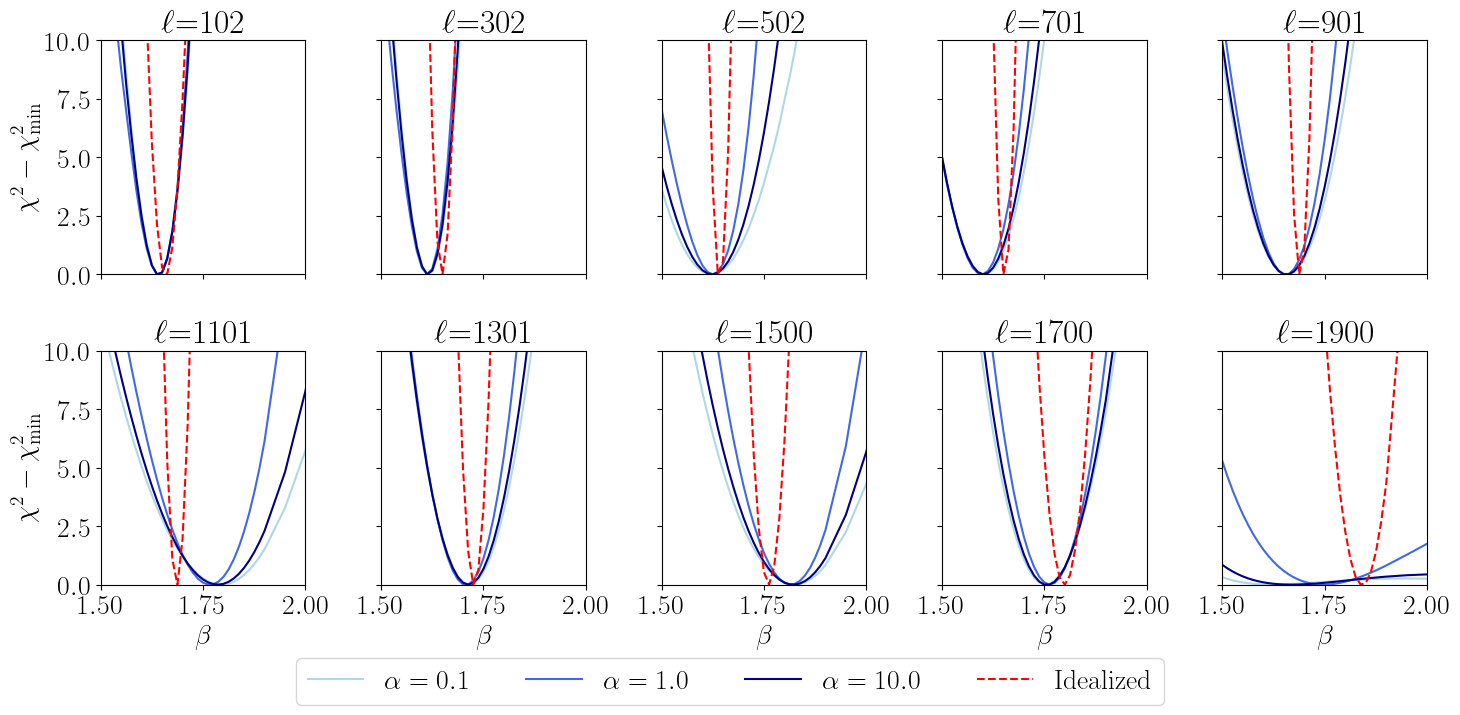

In [204]:
# Create a grid of 2 rows x 5 columns for 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

fmt = '-'
colors = ['lightblue', 'royalblue', 'navy']

for idx in range(10):
    ax = axes[idx]
    # Plot each set of data on the current subplot
    ax.plot(beta_arr, chi2_alpha0p1[idx]-min(chi2_alpha0p1[idx]), fmt, label=r'$\alpha=0.1$', color=colors[0])
    ax.plot(beta_arr, chi2_alpha1[idx]-min(chi2_alpha1[idx]), fmt, label=r'$\alpha=1.0$', color=colors[1])
    ax.plot(beta_arr, chi2_alpha10[idx]-min(chi2_alpha10[idx]), fmt, label=r'$\alpha=10.0$', color=colors[2])
    ax.plot(beta_arr, chi2_true[idx]-min(chi2_true[idx]), label=r'Idealized', color='red', linestyle='dashed')
    
    # Configure plot appearance
#     ax.set_yscale('log')
    if idx > 4:
        ax.set_xlabel(r'$\beta$')
    if idx == 0 or idx == 5:
        ax.set_ylabel(r'$\chi^2-\chi^2_{\rm min}$')
    ax.set_xlim(1.5, 2.0)
    ax.set_title(r"$\ell$="+f'{int(np.round(mean_ells[idx]))}')
    plt.ylim(bottom=0, top=10)
    
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.05), fontsize=20)

# # Adjust layout to prevent overlapping
plt.tight_layout()

if save:
    plt.savefig(f'{save_dir}/chi2_vs_beta.pdf', bbox_inches='tight')

# Plot $\beta$ (with 1$\sigma$ error) in each bin

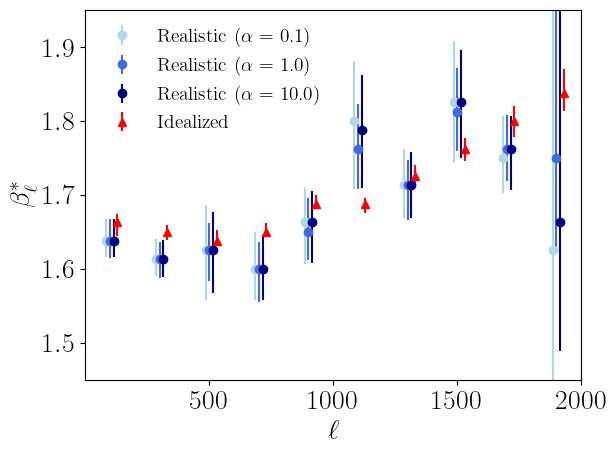

In [176]:
alpha = [0.1, 1.0, 10.0]
colors = ['lightblue', 'royalblue', 'navy']
for a, alpha_list in enumerate([beta_alpha0p1, beta_alpha1, beta_alpha10]):
    means_true, uppers_true, lowers_true, means_infl, uppers_infl, lowers_infl = alpha_list
    plt.errorbar(mean_ells+15*(a-1), means_infl, fmt='o', yerr=[lowers_infl, uppers_infl], label=r'Realistic ($\alpha=$'+f' {alpha[a]})', color=colors[a])
plt.errorbar(mean_ells+15*2, means_true, fmt='^', yerr=[lowers_true, uppers_true], label=f'Idealized', color='red')
plt.legend(loc='upper left', frameon=False, fontsize=14)
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel(r'$\beta^{*}_\ell$', fontsize=20)
plt.ylim(1.45,1.95)
plt.xlim(ellmin, ellmax)

if save:
    plt.savefig(f'{save_dir}/beta_vs_ell.pdf', bbox_inches='tight')


# Compare to $\beta$+$d\beta$

In [13]:
y_beta = hp.read_map(f"{base_dir1}/pyilc_outputs/final/needletILCmap_component_tSZ_deproject_CIB_realistic.fits")
y_beta_dbeta = hp.read_map(f"{base_dir1}/pyilc_outputs/final/needletILCmap_component_tSZ_deproject_CIB_CIB_dbeta.fits")
yopt = hp.read_map(f'{base_dir1}/pyilc_outputs/uninflated/needletILCmap_component_tSZ.fits')

ytrue = hp.read_map('/Users/kristen/Documents/GitHub/CIB-deproj/inputs/agora/tsz_1024.fits')
h = hp.read_map('/Users/kristen/Documents/GitHub/CIB-deproj/inputs/halo_zsel_0.8_to_1.8_Msel_1e12_to_1e15_rot120.fits')



In [6]:
def binned(spectrum):
    '''
    ARGUMENTS
    ---------
    spectrum: 1D numpy array of length ellmax+1 containing some power spectrum

    RETURNS
    -------
    binned_spectrum: 1D numpy array of length Nbins containing binned power spectrum
    '''
    ells = np.arange(ellmax+1)
    Dl = ells*(ells+1)/2/np.pi*spectrum
    Nbins = int(np.round((ellmax-ellmin+1)/ells_per_bin))
    res = stats.binned_statistic(ells[ellmin:], Dl[ellmin:], statistic='mean', bins=Nbins)
    mean_ells = (res[1][:-1]+res[1][1:])/2
    binned_spectrum = res[0]/(mean_ells*(mean_ells+1)/2/np.pi)
    return binned_spectrum

In [7]:
def harmonic_space_cov(xx, yy, xy):
    '''
    ARGUMENTS
    ---------
    xx, yy, xy: (Nbins, ) array containing auto- and cross- spectra of x and y

    RETURNS
    -------
    cov_hy: (Nbins, Nbins) ndarray containing Gaussian covariance matrix of halos and (y1-y2)
    ''' 
    Nmodes = (2*mean_ells+1)*ells_per_bin
    cov_xy = np.diag(1/Nmodes*(xy**2 + xx*yy))
    return cov_xy

In [18]:
hxy_beta = binned(hp.anafast(h, y_beta, lmax=ellmax))
hxy_beta_dbeta = binned(hp.anafast(h, y_beta_dbeta, lmax=ellmax))
y_beta_dbetaxy_beta_dbeta = binned(hp.anafast(y_beta_dbeta, lmax=ellmax))
y_betaxy_beta = binned(hp.anafast(y_beta, lmax=ellmax))
ytruexytrue = binned(hp.anafast(ytrue, lmax=ellmax))
y_betaxytrue = binned(hp.anafast(y_beta, ytrue, lmax=ellmax))
y_beta_dbetaxytrue = binned(hp.anafast(y_beta_dbeta, ytrue, lmax=ellmax))
yoptxyopt = binned(hp.anafast(yopt, lmax=ellmax))
yoptxytrue = binned(hp.anafast(yopt, ytrue, lmax=ellmax))
yoptxh = binned(hp.anafast(yopt, h, lmax=ellmax))
hxytrue = binned(hp.anafast(h, ytrue, lmax=ellmax))
hh = binned(hp.anafast(h, lmax=ellmax))
ytruexytrue = binned(hp.anafast(ytrue, lmax=ellmax))

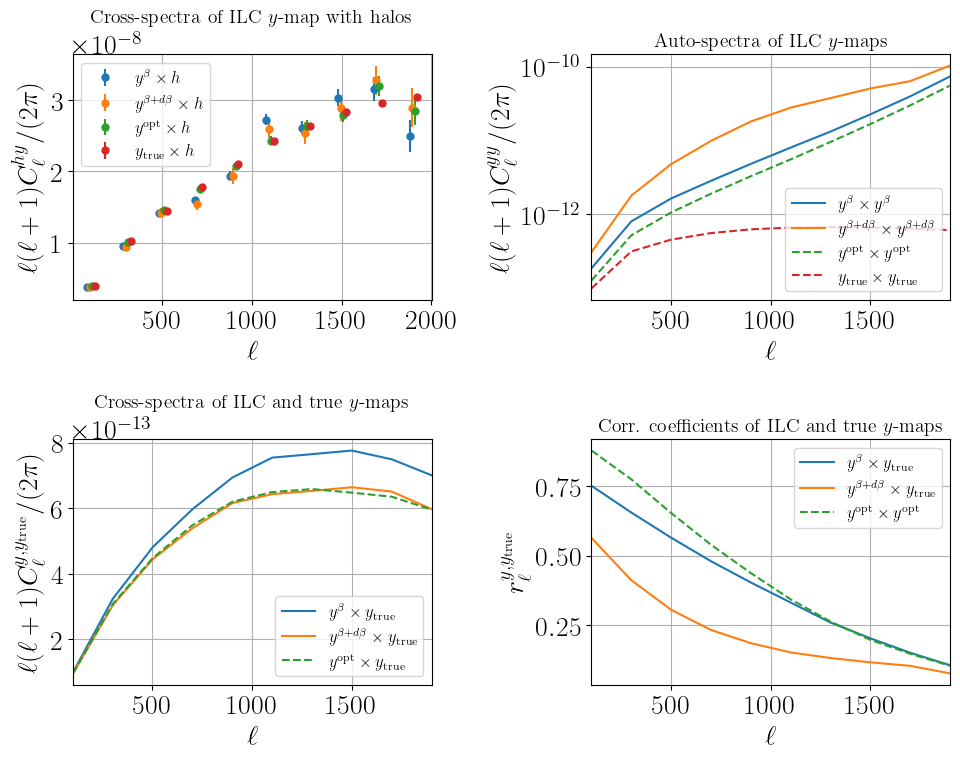

In [171]:
to_dl = mean_ells*(mean_ells+1)/2/np.pi
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.flatten()
for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        markersize = 5
        offset = 15
        hxy_beta_cov = harmonic_space_cov(hh, y_betaxy_beta, hxy_beta)
        hxy_beta_dbeta_cov = harmonic_space_cov(hh, y_beta_dbetaxy_beta_dbeta, hxy_beta_dbeta)
        hxyopt_cov = harmonic_space_cov(hh, yoptxyopt, yoptxh)
        hxytrue_cov = harmonic_space_cov(hh, ytruexytrue, hxytrue)
        fmt = 'o'
        plt.errorbar(mean_ells-offset//2-offset, to_dl*hxy_beta, yerr=to_dl*np.sqrt(np.diag(hxy_beta_cov)), label=r'$y^{\beta} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells-offset//2, to_dl*hxy_beta_dbeta, yerr=to_dl*np.sqrt(np.diag(hxy_beta_dbeta_cov)), label=r'$y^{\beta + d\beta} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells+offset//2, to_dl*yoptxh, yerr=to_dl*np.sqrt(np.diag(hxyopt_cov)), label=r'$y^{\rm opt} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells+offset//2+offset, to_dl*hxytrue, yerr=to_dl*np.sqrt(np.diag(hxytrue_cov)), label=r'$y_{\rm true} \times h$', fmt=fmt, markersize=markersize)
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{hy}/(2\pi)$')
        plt.grid()
        plt.xlim(2, ellmax+1)
        plt.title(r'Cross-spectra of ILC $y$-map with halos', fontsize=14)
    elif n==1:
        plt.plot(mean_ells, to_dl*y_betaxy_beta, label=r'$y^{\beta} \times y^{\beta}$')
        plt.plot(mean_ells, to_dl*y_beta_dbetaxy_beta_dbeta, label=r'$y^{\beta + d\beta} \times y^{\beta + d\beta}$')
        plt.plot(mean_ells, to_dl*yoptxyopt, label=r'$y^{\rm opt} \times y^{\rm opt}$', linestyle='dashed')
        plt.plot(mean_ells, to_dl*ytruexytrue, label=r'$y_{\rm true} \times y_{\rm true}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{yy}/(2\pi)$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.yscale('log')
        plt.title(r'Auto-spectra of ILC $y$-maps', fontsize=14)      
    elif n==2:
        plt.plot(mean_ells, to_dl*y_betaxytrue, label=r'$y^{\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells, to_dl*y_beta_dbetaxytrue, label=r'$y^{\beta+d\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells, to_dl*yoptxytrue, label=r'$y^{\rm opt} \times y_{\mathrm{true}}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{y,y_{\mathrm{true}}}/(2\pi)$')
        plt.grid(which='both')
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.title('Cross-spectra of ILC and true $y$-maps', fontsize=14)
    elif n==3:
        plt.plot(mean_ells,y_betaxytrue/np.sqrt(ytruexytrue*y_betaxy_beta), label=r'$y^{\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells,y_beta_dbetaxytrue/np.sqrt(ytruexytrue*y_beta_dbetaxy_beta_dbeta), label=r'$y^{\beta+d\beta} \times y_{\mathrm{true}}$')
        plt.plot(mean_ells,yoptxytrue/np.sqrt(ytruexytrue*yoptxyopt), label=r'$y^{\rm opt} \times y^{\rm opt}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$r_\ell^{y,y_{\mathrm{true}}}$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.title('Corr. coefficients of ILC and true $y$-maps', fontsize=14)
plt.tight_layout()

if save:
    plt.savefig(f'{save_dir}/dbeta_comparison.pdf', bbox_inches='tight')



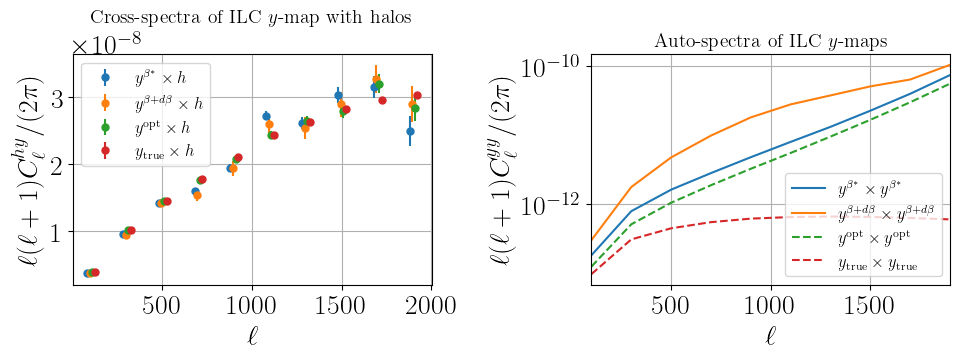

In [177]:
to_dl = mean_ells*(mean_ells+1)/2/np.pi
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flatten()
for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        markersize = 5
        offset = 15
        hxy_beta_cov = harmonic_space_cov(hh, y_betaxy_beta, hxy_beta)
        hxy_beta_dbeta_cov = harmonic_space_cov(hh, y_beta_dbetaxy_beta_dbeta, hxy_beta_dbeta)
        hxyopt_cov = harmonic_space_cov(hh, yoptxyopt, yoptxh)
        hxytrue_cov = harmonic_space_cov(hh, ytruexytrue, hxytrue)
        fmt = 'o'
        plt.errorbar(mean_ells-offset//2-offset, to_dl*hxy_beta, yerr=to_dl*np.sqrt(np.diag(hxy_beta_cov)), label=r'$y^{\beta^*} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells-offset//2, to_dl*hxy_beta_dbeta, yerr=to_dl*np.sqrt(np.diag(hxy_beta_dbeta_cov)), label=r'$y^{\beta + d\beta} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells+offset//2, to_dl*yoptxh, yerr=to_dl*np.sqrt(np.diag(hxyopt_cov)), label=r'$y^{\rm opt} \times h$', fmt=fmt, markersize=markersize)
        plt.errorbar(mean_ells+offset//2+offset, to_dl*hxytrue, yerr=to_dl*np.sqrt(np.diag(hxytrue_cov)), label=r'$y_{\rm true} \times h$', fmt=fmt, markersize=markersize)
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{hy}/(2\pi)$')
        plt.grid()
        plt.xlim(2, ellmax+1)
        plt.title(r'Cross-spectra of ILC $y$-map with halos', fontsize=14)
    elif n==1:
        plt.plot(mean_ells, to_dl*y_betaxy_beta, label=r'$y^{\beta^*} \times y^{\beta^*}$')
        plt.plot(mean_ells, to_dl*y_beta_dbetaxy_beta_dbeta, label=r'$y^{\beta + d\beta} \times y^{\beta + d\beta}$')
        plt.plot(mean_ells, to_dl*yoptxyopt, label=r'$y^{\rm opt} \times y^{\rm opt}$', linestyle='dashed')
        plt.plot(mean_ells, to_dl*ytruexytrue, label=r'$y_{\rm true} \times y_{\rm true}$', linestyle='dashed')
        plt.legend(fontsize=12)
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\ell(\ell+1)C_\ell^{yy}/(2\pi)$')
        plt.grid()
        plt.xlim(mean_ells[0], mean_ells[-1])
        plt.yscale('log')
        plt.title(r'Auto-spectra of ILC $y$-maps', fontsize=14)      
plt.tight_layout()

if save:
    plt.savefig(f'{save_dir}/dbeta_comparison.pdf', bbox_inches='tight')



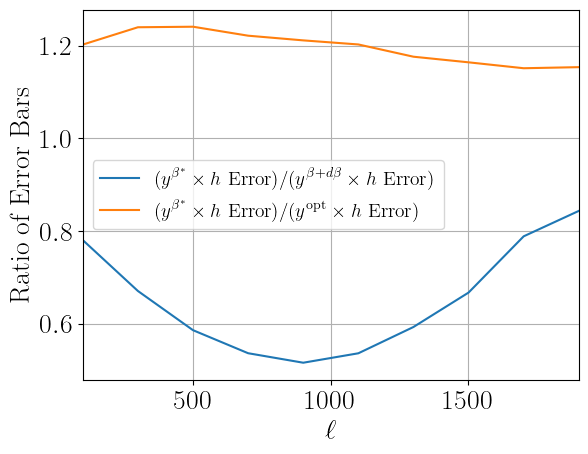

In [178]:
plt.plot(mean_ells, np.sqrt(np.diag(hxy_beta_cov))/np.sqrt(np.diag(hxy_beta_dbeta_cov)), label=r'($y^{\beta^*} \times h$ Error)/($y^{\beta + d\beta} \times h$ Error)')
plt.plot(mean_ells, np.sqrt(np.diag(hxy_beta_cov))/np.sqrt(np.diag(hxyopt_cov)), label=r'($y^{\beta^*} \times h$ Error)/($y^{\rm opt} \times h$ Error)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Ratio of Error Bars')
plt.xlim(mean_ells[0], mean_ells[-1])
plt.grid()
plt.legend(fontsize=14)
if save:
    plt.savefig(f'{save_dir}/error_ratio.pdf', bbox_inches='tight')


# Signal to Noise

In [185]:
def snr(spectrum, errorbar):
    return np.sqrt(np.sum(spectrum**2/errorbar**2))

print(snr(hxy_beta, np.sqrt(np.diag(hxy_beta_cov))))
print(snr(hxy_beta_dbeta, np.sqrt(np.diag(hxy_beta_dbeta_cov))))   
print(snr(yoptxh, np.sqrt(np.diag(hxyopt_cov)))) 


95.17882608124953
57.89441246649546
117.8498233274661


# Stacking

<Figure size 640x480 with 0 Axes>

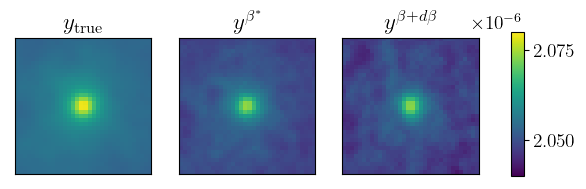

In [179]:
stacked_patch_2d_ytrue = pickle.load(open('stacks/stack_ytrue.p', 'rb'))
stacked_patch_2d_beta = pickle.load(open('stacks/stack_y_beta.p', 'rb'))
stacked_patch_2d_beta_dbeta = pickle.load(open('stacks/stack_y_beta_dbeta.p', 'rb'))


plt.clf()


plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 14})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

fig, axs = plt.subplots(1,3)
vmin = 2.04e-6
vmax = 2.08e-6

for a, ax in enumerate(axs):
    plt.axes(ax)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    if a == 0:
        im0 = plt.imshow(stacked_patch_2d_ytrue, vmin=vmin, vmax=vmax)
        plt.title(r'$y_{\rm true}$')
    elif a == 1:
        im1 = plt.imshow(stacked_patch_2d_beta, vmin=vmin, vmax=vmax)
        plt.title(r'$y^{\beta^*}$')
    else:
        im2 = plt.imshow(stacked_patch_2d_beta_dbeta, vmin=vmin, vmax=vmax)
        plt.title(r'$y^{\beta+d\beta}$')
        
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.90, 0.35, 0.02, 0.3])
fig.colorbar(im2, cax=cbar_ax)


if save:
    plt.savefig(f'{save_dir}/stacking.pdf', bbox_inches='tight')

plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size'   : 20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})


# Plot Simulated Sky PS

In [4]:
agora_dir = 'inputs/agora'
cmb_agora = hp.read_map(f'{agora_dir}/cmb_1024.fits')
tsz_agora = hp.read_map(f'{agora_dir}/tsz_1024.fits')
ksz_agora = hp.read_map(f'{agora_dir}/ksz_1024.fits')
cib_agora = [hp.read_map(f'{agora_dir}/cib/mdpl2_len_mag_cibmap_planck_{freq}_uk.fits') for freq in [100, 143, 217, 353, 545]]
h_agora = hp.read_map(f'{agora_dir}/halo.fits')



In [19]:
cmb_cl_agora = hp.anafast(cmb_agora, lmax=ellmax)
tsz_cl_agora = hp.anafast(tsz_agora, lmax=ellmax)
ksz_cl_agora = hp.anafast(ksz_agora, lmax=ellmax)
cib_cl_agora = [hp.anafast(cib_agora[i], lmax=ellmax) for i in range(len(cib_agora))]



In [34]:
def dBnudT(nu_ghz):
    '''
    ARGUMENTS
    ---------
    nu_ghz: array-like of frequencies (GHz) to evaluate

    RETURNS
    -------
    blackbody derivative in uK_CMB
    '''
    TCMB = 2.726 #Kelvin
    hplanck=6.626068e-34 #MKS
    kboltz=1.3806503e-23 #MKS
    clight=299792458.0 #MKS
    TCMB_uK = 2.726e6 #micro-Kelvin
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK

def tsz_delta_sed(freq):
    '''
    ARGUMENTS
    ---------
    freq: float, frequency (GHz) for which to calculate tSZ spectral response in a delta bandpass

    RETURNS
    ---------
    sed: float, tSZ spectral response to freq (units of K_CMB)
    '''
    T_cmb = 2.726
    T_cmb_uK = 2.726e6
    h = 6.62607004*10**(-34)
    kb = 1.38064852*10**(-23)
    x = h*(freq*10**9)/(kb*T_cmb) #x is v/56.9 GHz
    sed = T_cmb*(x*1/np.tanh(x/2)-4)
    return sed


def tsz_spectral_response(freqs, delta_bandpasses=True, bp_path=None):
    '''
    ARGUMENTS
    ---------
    freqs: array-like, contains frequencies (GHz) for which to calculate tSZ spectral response
    delta_bandpasses: Bool, if True, returns SED at freqs with Delta bandpasses;
        if False, returns SED evaluated at actual Planck bandpasses
    bp_path: str, If delta_bandpasses=False, must provide file path

    RETURNS
    ---------
    1D array containing tSZ spectral response to each frequency (units of K_CMB)
    '''
    response = []
    for freq in freqs:
        if delta_bandpasses:
            response.append(tsz_delta_sed(freq))
        else:
            bp_path = f'{bp_path}/data/HFI_BANDPASS_F{int(freq)}_reformat.txt'
            nu_ghz, trans = np.loadtxt(bp_path, usecols=(0,1), unpack=True)
            delta_resp = np.array([tsz_delta_sed(n) for n in nu_ghz])
            val = np.trapz(trans * dBnudT(nu_ghz) * delta_resp, nu_ghz) / np.trapz(trans * dBnudT(nu_ghz), nu_ghz)
            response.append(val) #K_CMB
    return np.array(response)

In [40]:
def get_planck_noise():
    '''
    RETURNS
    -------
    PS_noise_Planck: (Nfreqs_Planck, ellmax+1) ndarray containing Planck noise power spectra in uK^2
        first dimension is of size 5 for frequencies 100, 143, 217, 353, 545

    '''
    ellmax = 2000
    Nfreqs_Planck = 5
    freqs_Planck = []
    freqs_Planck.append('100')
    freqs_Planck.append('143')
    freqs_Planck.append('217')
    freqs_Planck.append('353')
    freqs_Planck.append('545')
    
    # Planck white noise
    noise_arr_Planck = np.zeros(Nfreqs_Planck)
    noise_arr_Planck[0] = 77.4 #uK-arcmin, from Table 6 of https://arxiv.org/pdf/1502.01587v2.pdf
    noise_arr_Planck[1] = 33.0
    noise_arr_Planck[2] = 46.8
    noise_arr_Planck[3] = 153.6
    noise_arr_Planck[4] = 0.78 * 1e-3 * 0.01723080316 * 1e6 * 60 #kJy/sr * deg --> converted to uK-arcmin

    # Planck beams
    FWHM_arr_Planck = np.zeros(Nfreqs_Planck)
    FWHM_arr_Planck[0] = 9.69 #arcmin, from Table 6 of https://arxiv.org/pdf/1502.01587v2.pdf
    FWHM_arr_Planck[1] = 7.30
    FWHM_arr_Planck[2] = 5.02
    FWHM_arr_Planck[3] = 4.94
    FWHM_arr_Planck[4] = 4.83 #arcmin

    # convert to sigma in radians
    sigma_arr_Planck = FWHM_arr_Planck / np.sqrt(8. * np.log(2)) /60. * np.pi/180.
    # Planck noise power spectra
    MAX_NOISE = 1.e9
    delta_ell = 1
    ell = np.arange(0, ellmax+1, delta_ell)
    PS_noise_Planck = np.zeros((Nfreqs_Planck, int(ellmax)+1))
    for i in range(Nfreqs_Planck):
        PS_noise_Planck[i] = (noise_arr_Planck[i] * (1.0/60.0) * (np.pi/180.0))**2.0 * np.exp( ell*(ell+1)* sigma_arr_Planck[i]**2. ) #square to get the white-noise level -- see e.g. Eq. 2.32 (pg 15) of https://arxiv.org/pdf/1509.06770v4.pdf
        # handle overflow due to high noise at high ell
        PS_noise_Planck[i][(np.where(PS_noise_Planck[i] > MAX_NOISE))[0]] = MAX_NOISE

    return PS_noise_Planck



In [67]:
tsz_cib_cl_agora = [hp.anafast(cib_agora[i], tsz_agora*10**6*tsz_spectral_response([freqs[i]], False, bp_path), lmax=ellmax) for i in range(len(cib_agora))]




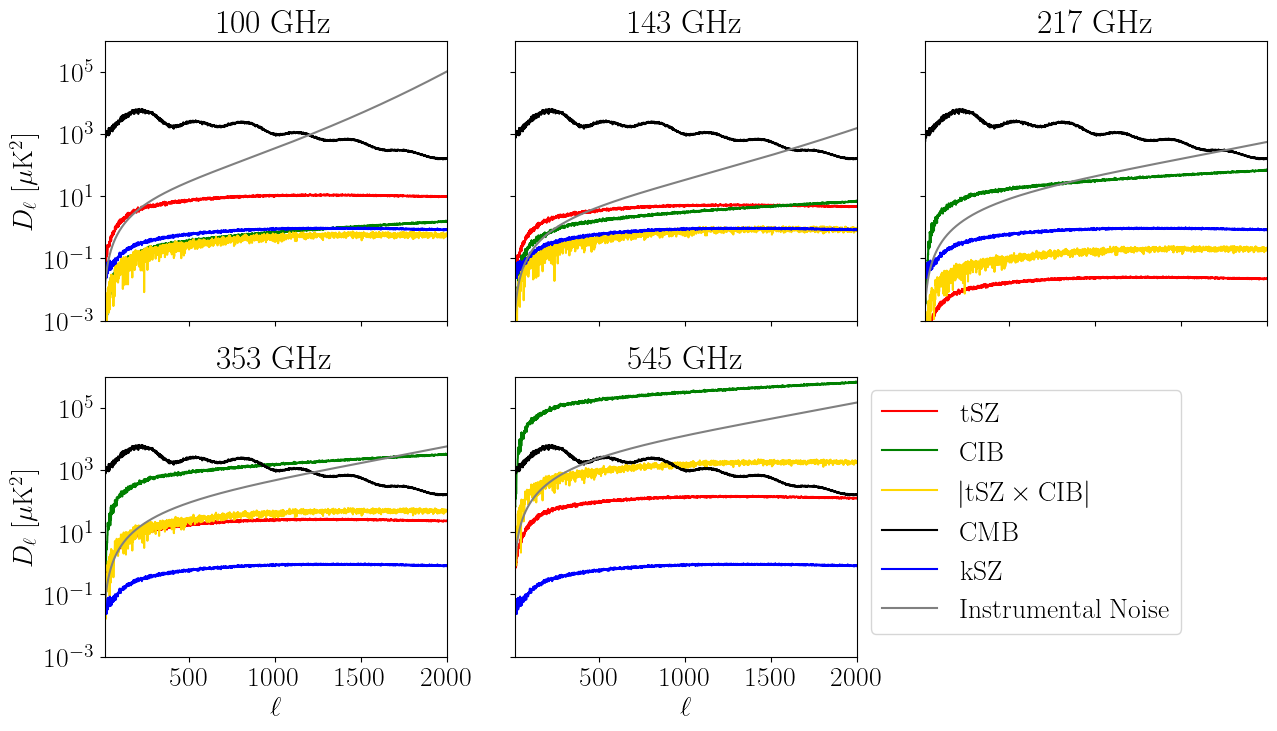

In [70]:
# 1) Define your frequencies and components
freqs = [100, 143, 217, 353, 545]  # in GHz
components = ['tSZ', 'CIB', r'$|\mathrm{tSZ} \times \mathrm{CIB}|$', 'CMB', 'kSZ', 'Instrumental Noise',]

# 2) (Dummy) load or compute your spectra:
ells = np.arange(ellmax+1)
to_dl = ells*(ells+1)/2/np.pi
ps = {}
for comp in components:
    powlaw = (ell + 1)**(-1.)
    if comp == 'CMB':
        ps[comp] = np.array([cmb_cl_agora for i in range(len(freqs))])
    elif comp == 'kSZ':
        ps[comp] = np.array([ksz_cl_agora for i in range(len(freqs))])
    elif comp == 'CIB':
        ps[comp] = np.array(cib_cl_agora)
    elif comp == 'tSZ':
        bp_path = '/Users/kristen/Documents/GitHub/pyilc'
        ps[comp] = np.abs(np.array([10**12*tsz_cl_agora*tsz_spectral_response([freqs[i]], False, bp_path)**2 for i in range(len(freqs))]))
    elif comp == 'Instrumental Noise':
        ps[comp] = np.array(get_planck_noise())
    elif comp == r'$|\mathrm{tSZ} \times \mathrm{CIB}|$':
        ps[comp] = np.abs(np.array(tsz_cib_cl_agora))

# 3) plotting in a 2×3 grid
colors = {
    'CMB': 'k',
    'kSZ': 'b',
    'tSZ': 'r',
    'CIB': 'g',
    'Instrumental Noise': 'gray', 
    r'$|\mathrm{tSZ} \times \mathrm{CIB}|$': 'gold'
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True, sharex=True)
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    if i < len(freqs):
        nu = freqs[i]
        for c, comp in enumerate(components):
            ax.plot(ells[10:], (to_dl*ps[comp][i])[10:], label=comp, color=colors[comp])
        ax.set_title(f'{nu} GHz')
        if i > 2:
            ax.set_xlabel(r'$\ell$', fontsize=20)
        if i % 3 == 0:
            ax.set_ylabel(r'$D_\ell$ [$\mu \mathrm{K}^2$]', fontsize=20)
        # only draw one legend, on the last plotted panel
        if i == len(freqs) - 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_yscale('log')
        ax.set_xlim(10, ellmax)
        ax.set_ylim(bottom=10**(-3), top=10**6)
    else:
        # hide any unused axes (here the bottom-right corner)
        ax.axis('off')

if save:
    plt.savefig(f'{save_dir}/comp_ps.pdf', bbox_inches='tight')

# CIB x h

In [5]:
cib_dir = f'/Users/kristen/Documents/GitHub/CIB-deproj/inputs/agora/cib'
cib_100 = hp.read_map(f'{cib_dir}/mdpl2_len_mag_cibmap_planck_100_uk.fits')
cib_143 = hp.read_map(f'{cib_dir}/mdpl2_len_mag_cibmap_planck_143_uk.fits')
cib_217 = hp.read_map(f'{cib_dir}/mdpl2_len_mag_cibmap_planck_217_uk.fits')
cib_353 = hp.read_map(f'{cib_dir}/mdpl2_len_mag_cibmap_planck_353_uk.fits')
cib_545 = hp.read_map(f'{cib_dir}/mdpl2_len_mag_cibmap_planck_545_uk.fits')
h = hp.read_map(f'{dir}/maps/halo.fits')

In [14]:
cib_100_cl = binned(hp.anafast(cib_100, h, lmax=ellmax))
cib_143_cl = binned(hp.anafast(cib_143, h, lmax=ellmax))
cib_217_cl = binned(hp.anafast(cib_217, h, lmax=ellmax))
cib_353_cl = binned(hp.anafast(cib_353, h, lmax=ellmax))
cib_545_cl = binned(hp.anafast(cib_545, h, lmax=ellmax))


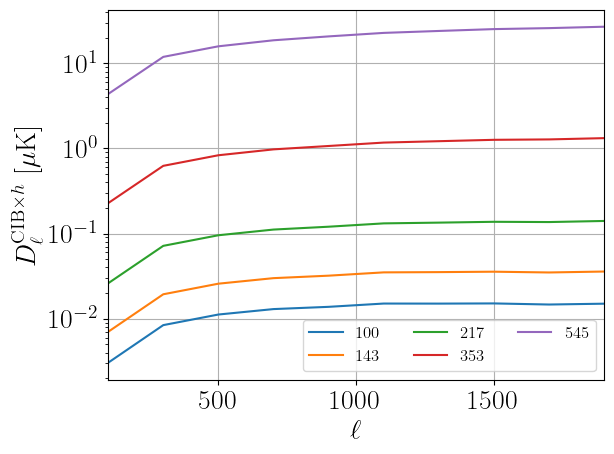

In [23]:
to_dl = mean_ells*(mean_ells+1)/2/np.pi
plt.plot(mean_ells, (to_dl*cib_100_cl), label='100')
plt.plot(mean_ells, (to_dl*cib_143_cl), label='143')
plt.plot(mean_ells, (to_dl*cib_217_cl), label='217')
plt.plot(mean_ells, (to_dl*cib_353_cl), label='353')
plt.plot(mean_ells, (to_dl*cib_545_cl), label='545')
plt.legend(fontsize=12, ncol=3)
plt.grid()
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell^{\mathrm{CIB} \times h}$ [$\mu \mathrm{K}$]')
plt.xlim(mean_ells[0],mean_ells[-1])
plt.savefig('cibxh.pdf', bbox_inches='tight')